<a href="https://colab.research.google.com/github/sungjuGit/COSMOS_Ju/blob/main/COSMOS_ML_04_CNN_LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LeNet

In this notebook, we will be implementing a modified version of [LeNet-5](http://yann.lecun.com/exdb/lenet/), a neural network model that uses convolutional neural network (CNN) layers and was designed for [classifying handwritten characters](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).

CNNs are ubiquitous in modern computer vision. Almost every neural network model for computer vision contains many CNN layers, also referred to as convolutional layers, thus they're an important concept to understand. We will explain how they work when we implement the model.

The image below shows the architecture of LeNet-5. It consists of two convolutional layers, each followed by a subsampling layer, and then three fully connected linear layers.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/lenet5.png?raw=1)


Most of this notebook will be similar to the previous one.

This notebook was adapted from (https://github.com/bentrevett/pytorch-image-classification).

---
## Set Things Up

In [ ]:
# @title Import Modules

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

import time
import random

SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

The first thing we'll do is load our dataset. This will automatically download the training set for the MNIST dataset and save it in a folder called `.data`. It will create the folder if it does not exist.

In [ ]:
ROOT = '.data'

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 86077364.25it/s]


Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 115477305.84it/s]


Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 40508955.32it/s]


Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1167311.81it/s]

Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw



Next, we want to *normalize* our data. This means we want it to have a mean of zero and a standard deviation of one.

Why do we want to do this? Normalizing our data allows our models to train faster and to also help them avoid local minima, i.e. train more reliably.

The image data has values between 0-255, which we want to scale between 0-1, so we divide by 255.

In [ ]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

Now we've calculated our mean and standard deviation how do we actually use them? We use Torchvision's `transforms`.

A `transform` states how our data should be augmented and processed. Data augmentation involves manipulating the available training data in a way that artificially creates more training examples. We use `transforms.Compose` to built a list of transformations that will be applied to the image.

In [ ]:
# @title Transform data
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

Now we have defined our transforms we can then load the train and test data with the relevant transforms defined.

In [ ]:
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

---
## Check Out Data

We can simply check the `len` of the datasets to see how many examples are within each.

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


The LeNet architectures, and almost every modern neural network computer vision architecture, makes use of convolutional neural network (CNN) layers.

CNNs are inspired by classic computer vision techniques, like [Sobel filters](https://en.wikipedia.org/wiki/Sobel_operator). Let's try manually choosing weights of a 3x3 filter to make Sobel filters and apply them to some MNIST digits to see what type of things our CNN layers can learn.

The `plot_filter` function takes in a batch of images and a two-dimensional filter and plots the output of that filter applied to all of the images.

In [ ]:
# @title Plot Filter function
def plot_filter(images, filter):

    images = images = torch.cat([i.unsqueeze(0) for i in images],
                                dim=0).cpu()
    filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()

    n_images = images.shape[0]

    filtered_images = F.conv2d(images, filter)

    fig = plt.figure(figsize=(20, 5))

    for i in range(n_images):

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        image = filtered_images[i].squeeze(0)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image, cmap='bone')
        ax.set_title('Filtered')
        ax.axis('off')

We'll then get a batch of images to test our handwritten Sobel filters on. We get the images from the test set, as they're easier to examine without the transforms applied to them.

In [ ]:
N_IMAGES = 5

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]

The first filter is for detecting horizontal lines.

We can see on the filtered images that the highest values (the whitest pixels) of the filtered image are where there is a horizontal line that is black on top and white below, e.g. the top of the 7 digit. The lowest values (the blackest pixels) of the filtered image are where there is a horizontal line that goes from white to black, e.g. the bottoms of all the digits.

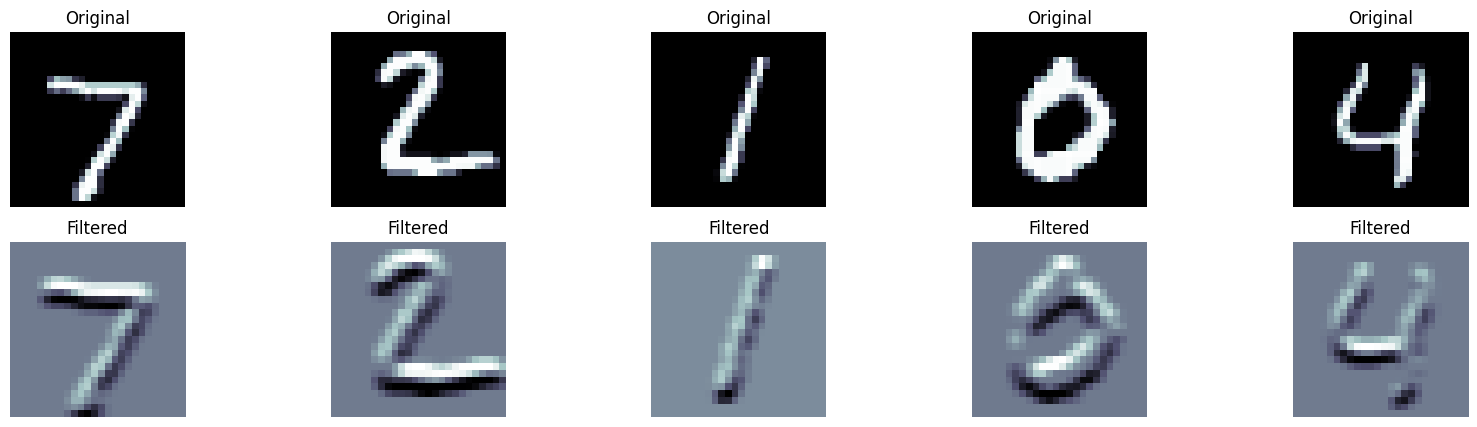

In [ ]:
horizontal_filter = [[-1, -2, -1],
                     [ 0,  0,  0],
                     [ 1,  2,  1]]

plot_filter(images, horizontal_filter)

We can also design filters that detect vertical lines.

Here's one that detects vertical lines that are black on the left and white on the right.

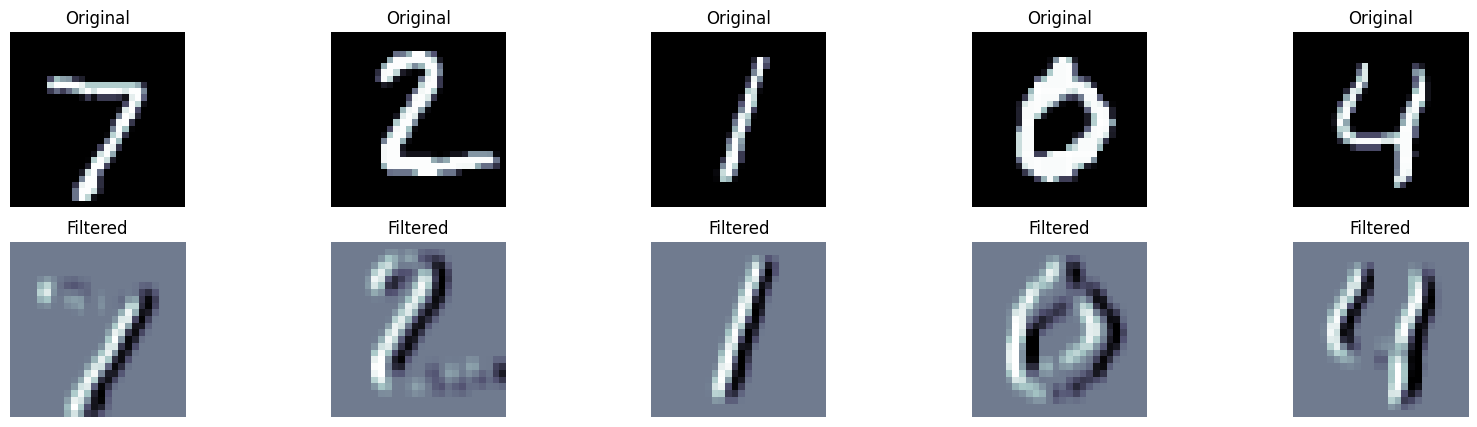

In [ ]:
vertical_filter = [[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]]

plot_filter(images, vertical_filter)

Next, we'll define a `DataLoader` for each of the training and test sets. We can iterate over these, and they will yield batches of images and labels which we can use to train our model.

We only need to shuffle our training set as it will be used for stochastic gradient descent, and we want each batch to be different between epochs.

Ideally, we want to use the biggest batch size that we can. The 64 here is relatively small and can be increased if our hardware can handle it.

In [ ]:
BATCH_SIZE = 64

train_loader = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)
test_loader = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

---
## Define the Model

Now we've gone through all the concepts, we can implement our model.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/lenet5.png?raw=1)

Our actual implementation is going to slightly differ from the actual LeNet architecture, as it was built to handle 32x32 images, whereas the MNIST dataset consists of 28x28 images. We're also not going to use the Gaussian connections at the end, instead we'll just use a standard linear layer.

The first layer in our model is a convolutional layer with 6 filters (PyTorch calls them `out_channels`) and a kernel size of 5. This turns our `[1, 28, 28]` image into `[6, 24, 24]`. We then downsample our image with a max pooling layer that has a filter size of 2 to get a `[6, 12, 12]` image. This is then passed through an activation function, ReLU in this case, which is applied elementwise and does not change the of the image.

Afterwards, we pass the image to the second convolutional layer with 16 filters that are 5x5x6, a height and width of 5 and a depth of 6 as our previous convolutional layer had 6 filters. This gives us an image size of `[16, 8, 8]` which we then max pool to half the height and width to `[16, 4, 4]` and then pass through another ReLU function.

We then flatten our `[16, 4, 4]` image to `[256]` and pass this through three linear layers. Each of the linear layers are followed by another ReLU, except for the last.

We return the results from the final linear layer as well as from the flattened result of the second convolutional layer, which we can plot in lower dimensions later.

In [ ]:
OUTPUT_DIM = 10

model = nn.Sequential(

            # x = [batch size, 1, 28, 28]

            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            # x = [batch size, 6, 24, 24]
            nn.MaxPool2d(kernel_size=2),
            # x = [batch size, 6, 12, 12]
            nn.ReLU(),

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            # x = [batch size, 16, 8, 8]
            nn.MaxPool2d(kernel_size=2),
            # x = [batch size, 16, 4, 4]
            nn.ReLU(),

            nn.Flatten(),
            # x = [batch size, 16*4*4 = 256]

            nn.Linear(16 * 4 * 4, 120),
            # x = [batch size, 120]
            nn.ReLU(),

            nn.Linear(120, 84),
            # x = [batch size, 84]
            nn.ReLU(),

            nn.Linear(84, OUTPUT_DIM),
            # x = [batch size, output dim]

        )

Let's calculate the number of trainable parameters (weights and biases) in our model.

In [ ]:
# @title Number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 44,426 trainable parameters


---
## Train and Test the Model

- pass a batch of data through your model
- calculate the loss of your batch by comparing your model's predictions against the actual labels
- calculate the gradient of each of your parameters with respect to the loss
- update each of your parameters by subtracting their gradient multiplied by a small *learning rate* parameter


In [ ]:
optimizer = optim.Adam(model.parameters())

We use as our loss `CrossEntropyLoss`

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# @title Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
loss_fn = loss_fn.to(device)

Next, we'll define a function to calculate the accuracy of our model. This takes the index of the highest value for your prediction and compares it against the actual class label. We then divide how many our model got correct by the amount in the batch to calculate accuracy across the batch.

In [ ]:
# @title Function to calculate accuracy
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, loader, optimizer, loss_fn, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in loader:

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = loss_fn(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

The final step before training is to define a small function to tell us how long an epoch took.

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We're finally ready to train!

During each epoch we calculate the training loss and accuracy, followed by the validation loss and accuracy. We then check if the validation loss achieved is the best validation loss we have seen. If so, we save our model's parameters (called a `state_dict`).

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn, device)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 27s
	Train Loss: 0.377 | Train Acc: 88.16%
Epoch: 02 | Epoch Time: 0m 28s
	Train Loss: 0.123 | Train Acc: 96.21%
Epoch: 03 | Epoch Time: 0m 28s
	Train Loss: 0.091 | Train Acc: 97.17%
Epoch: 04 | Epoch Time: 0m 27s
	Train Loss: 0.078 | Train Acc: 97.52%
Epoch: 05 | Epoch Time: 0m 27s
	Train Loss: 0.069 | Train Acc: 97.82%
Epoch: 06 | Epoch Time: 0m 27s
	Train Loss: 0.062 | Train Acc: 98.03%
Epoch: 07 | Epoch Time: 0m 28s
	Train Loss: 0.058 | Train Acc: 98.19%
Epoch: 08 | Epoch Time: 0m 28s
	Train Loss: 0.053 | Train Acc: 98.38%
Epoch: 09 | Epoch Time: 0m 28s
	Train Loss: 0.049 | Train Acc: 98.44%
Epoch: 10 | Epoch Time: 0m 28s
	Train Loss: 0.047 | Train Acc: 98.52%


tensor([8], device='cuda:0')


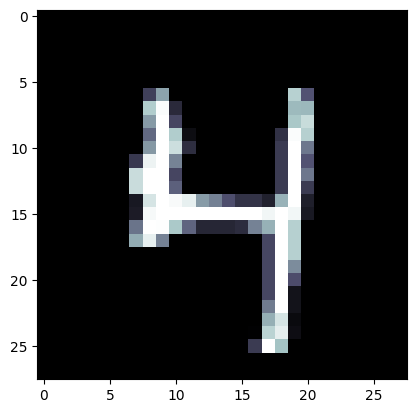

In [ ]:
test_idx = random.randint(0,10000-1) # out of 10000

model.eval()

with torch.no_grad():
  test_pred = model(test_data[test_idx][0].unsqueeze_(0).to(device))
  prob = torch.softmax(test_pred, dim=-1)
  print(torch.argmax(prob, 1))

plt.imshow(test_data[test_idx][0].view(28, 28).cpu().numpy(), cmap='bone')


The evaluation loop is similar to the training loop. The differences are:
- we put our model into evaluation mode with `model.eval()`
- we wrap the iterations inside a `with torch.no_grad()`
- we do not zero gradients as we are not calculating any
- we do not calculate gradients as we are not updating parameters
- we do not take an optimizer step as we are not calculating gradients

`torch.no_grad()` ensures that gradients are not calculated for whatever is inside the `with` block. As our model will not have to calculate gradients, it will be faster and use less memory.

In [ ]:
def evaluate(model, loader, loss_fn, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in loader:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = loss_fn(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.030 | Test Acc: 99.23%
